### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import importlib

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

### Definitions

In [2]:
# Define directories where processed hdf5s are stored
dir_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

### Load crowns' features of all hdf5s

In [3]:
importlib.reload(io)

df, params_df = io.allhdf5s_crowns_features_to_dataframe(dir_hdf5, crowns_type='crowns_human')

### Inspect the features

#### Optionally print some infos about features

In [5]:
print(params_df['io.allhdf5s_crowns_features_to_dataframe()_info'])
print()

n_crowns_mean = len(df) / len(np.unique(df.tnr))


for key in params_df.keys():
    print(f"tnr {key} contains {np.sum(np.array(df.tnr == key))} crowns")
print()
print(f"-> Total number of crowns: {len(df)}")
print(f"-> Mean number of crowns per tnr: {n_crowns_mean}")

print()
df.info()

[]

tnr 10527 contains 26 crowns
tnr 10533 contains 45 crowns
tnr 10545 contains 36 crowns
tnr 10547 contains 41 crowns
tnr 10912 contains 5 crowns
tnr 11 contains 8 crowns
tnr 11032 contains 29 crowns
tnr 11040 contains 30 crowns
tnr 11044 contains 54 crowns
tnr 11048 contains 47 crowns
tnr 11052 contains 52 crowns
tnr 11056 contains 29 crowns
tnr 11078 contains 41 crowns
tnr 11080 contains 59 crowns
tnr 11090 contains 39 crowns
tnr 11092 contains 40 crowns
tnr 11179 contains 12 crowns
tnr 11189 contains 19 crowns
tnr 11325 contains 7 crowns
tnr 11327 contains 6 crowns
tnr 11453 contains 12 crowns
tnr 11459 contains 13 crowns
tnr 11610 contains 11 crowns
tnr 11622 contains 45 crowns
tnr 11626 contains 48 crowns
tnr 11638 contains 57 crowns
tnr 11640 contains 51 crowns
tnr 11727 contains 14 crowns
tnr 11729 contains 7 crowns
tnr 11733 contains 15 crowns
tnr 11866 contains 14 crowns
tnr 11874 contains 21 crowns
tnr 11878 contains 9 crowns
tnr 12013 contains 6 crowns
tnr 12019 contains 1

#### Plot histograms

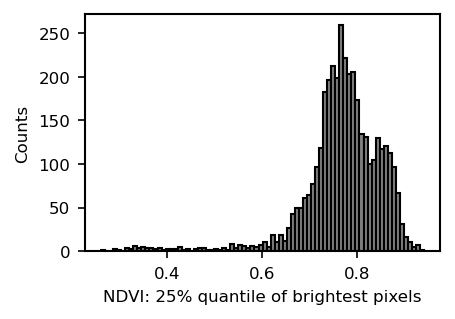

In [8]:
############### Define a query string to filter all features
query_str = 'ba >= 0'
# query_str = 'ba in [134]' # Select 'Gemeine Kiefer'
# query_str = 'ba in [118]' # Select 'Gemeine Fichte'
# query_str = 'ba in [100]' # Select Weißtanne'

############### Which feature to plot
name = ('perc25_brightest_ndvi', r'NDVI: 25% quantile of brightest pixels')
bins = 80

############### Plot histogram
f = plt.figure()
ax = f.add_subplot(111)
_ = ax.hist(
    df.query(query_str)[name[0]],
    bins=bins,
    fc='grey',
    ec='black',
    )
_ = ax.set_ylabel('Counts')
_ = ax.set_xlabel(name[1])

#### List counts of tree species

In [9]:
# Get unique species ids and counts
ids, counts = np.unique(df['ba'], return_counts=True)

# Sort from highest count to lowest count
sort_idx= np.flip(np.argsort(counts))
counts = counts[sort_idx]
ids = ids[sort_idx]

# Get mapper dict from species id to name
mapper = descriptions.species_id_to_name()

print(f"Total number of trees: {len(df)}")
print()
print(f"{'id':<3}| {'name':<25}| {'count'}")
print('-'*40)
for id, count in zip(ids, counts):    
    print(f"{id:<3}| {mapper[id]:<25}: {count}")

Total number of trees: 3895

id | name                     | count
----------------------------------------
134| Gemeine Kiefer           : 1544
118| Gemeine Fichte           : 945
20 | Rotbuche                 : 448
100| Weißtanne                : 207
48 | Traubeneiche             : 203
116| Europäische Lärche       : 117
51 | Stieleiche               : 93
10 | Gemeine Birke            : 44
22 | Gemeine Esche            : 43
7  | Schwarzerle              : 38
13 | Hainbuche                : 34
136| Douglasie                : 33
5  | Bergahorn                : 23
129| Schwarzkiefer            : 16
36 | Kirsche                  : 15
1  | Feldahorn                : 14
68 | Winterlinde              : 13
53 | Roteiche                 : 12
62 | Weide                    : 11
117| Japanische Lärche        : 11
35 | Aspe                     : 8
64 | Vogelbeere               : 7
133| Strobe                   : 4
4  | Spitzahorn               : 4
70 | Bergulme                 : 3
38 | Frühblühen

#### Scatter plot: 'Nadel Blatt Verlust' vs. Vegetation Indices for spec. tree species

,tnr,id,nbv,perc25_brightest_ndvi
176,11032,16,100.0,0.875021
833,11640,23,100.0,0.846105


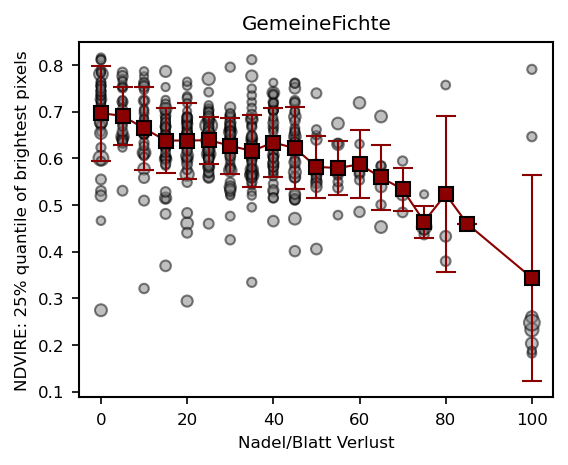

In [56]:
# Tree species mapper
mapper = descriptions.species_id_to_name()

############### Define a query string to filter all features
# query_str = 'ba >= 0' # Select all tree species

ba_ids = [134] # Select 'Gemeine Kiefer'
ba_ids = [118] # Select 'Gemeine Fichte'
# ba_ids = [20] # Select 'Rotbuche'
# ba_ids = [100] # Select 'Weißtanne'


query_str = 'ba in @ba_ids' # Query for tree species
query_str += ' and min_brightest_light > 1.5e-2' # Select all with min value of brightest px above fixed threshold
query_str += ' and kkl in [1,2]'
query_str += ' and n_px_brightest > 10'

############### Which feature to plot
name_x = ('nbv', r'Nadel/Blatt Verlust')
# name_x = ('sst', r'Schadstufe')
# name_x = ('perc25_brightest_ndvi', r'NDVI: 25% quantile of brightest pixels')

# name_y = ('median_ndvi', r'NDVI: Median of all pixels')
# name_y = ('perc25_brightest_ndvi', r'NDVI: 25% quantile of brightest pixels')
name_y = ('perc25_brightest_ndvire', r'NDVIRE: 25% quantile of brightest pixels')
# name_y = ('perc25_brightest_ndre', r'NDRE: 25% quantile of brightest pixels')
# name_y = ('perc25_brightest_grvi', r'GRVI: 25% quantile of brightest pixels')

############### Some plotting specs
xlim = [-5, 105] # For nbv
# xlim = [-.2, 4.2] # For sst
ylim = [0.2, 0.95] # For NDVI and NDVIRE
# ylim = [0., 0.4] # For NDRE

title_str = ''
for id in ba_ids: title_str += mapper[id].replace(' ', '') + '-'
title_str = title_str[:-1]

save_dir = r"C:\Users\flori\Documents\prof\lwf\plots\220722\nbv_vs_vegidx"
save_name = title_str + '__' + name_y[0] + '.pdf'

############### Plot histogram
x = np.array(df.query(query_str).loc[:, name_x[0]])
y = np.array(df.query(query_str).loc[:, name_y[0]])
s = np.array(df.query(query_str).loc[:, 'min_brightest_light']) * 1000

f = plt.figure(figsize= [4, 3])
ax = f.add_subplot(111)

# Scatter plot
_ = ax.scatter(
    x,
    y,
    s=s,
    fc='grey',
    ec='k',
    alpha=0.5,
    )

# Errorbar plot for uniqe x values and respective y means
x_unique = np.unique(x)
y_unique = np.array([np.nanmean(y[np.where(x == xu)[0]]) for xu in x_unique])
y_unique_err = np.array([np.nanstd(y[np.where(x == xu)[0]]) for xu in x_unique])

_ = ax.errorbar(
    x_unique,
    y_unique,
    y_unique_err,
    fmt='-s',
    ms=7,
    color='darkred',
    mec='k',
    mfc='darkred',
    capsize=5,
    )


ax.set_title(title_str)
_ = ax.set_xlabel(name_x[1])
_ = ax.set_ylabel(name_y[1])
# _ = ax.set_xlim(xlim)
# _ = ax.set_ylim(ylim)

# plt.savefig(os.path.join(save_dir, save_name), transparent=True)

df.query('nbv > 90 and perc25_brightest_ndvi > 0.8 and ba == 118')[['tnr', 'id', 'nbv', 'perc25_brightest_ndvi']]

#### Scatter plot: Lightness vs. Vegetation Indices for spec. tree species

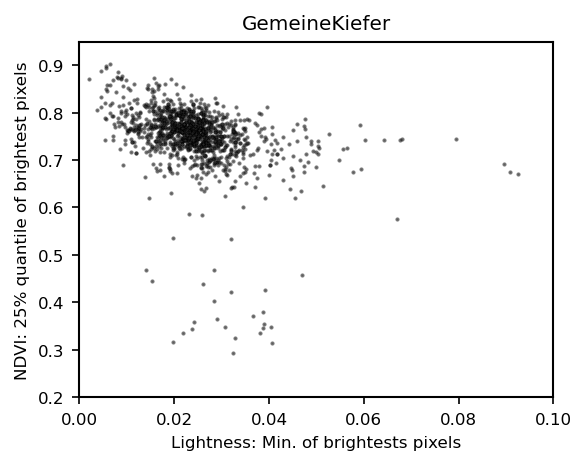

In [45]:
# Tree species mapper
mapper = descriptions.species_id_to_name()

############### Define a query string to filter all features
query_str = 'ba >= 0' # Select all tree species

ba_ids = [134] # Select 'Gemeine Kiefer'
# ba_ids = [118] # Select 'Gemeine Fichte'

query_str = 'ba in @ba_ids' # Query for tree species
query_str += ' and kkl in [1,2]'
query_str += ' and n_px_brightest > 10'

############### Which feature to plot
name_x = ('min_brightest_light', r'Lightness: Min. of brightests pixels')
name_y = ('perc25_brightest_ndvi', r'NDVI: 25% quantile of brightest pixels')


############### Some plotting specs
xlim = [0, 1e-1]
ylim = [0.2, 0.95] # For NDVI

title_str = ''
for id in ba_ids: title_str += mapper[id].replace(' ', '') + '-'
title_str = title_str[:-1]

save_dir = r"C:\Users\flori\Documents\prof\lwf\plots\220722\light_vs_vegidx"
save_name = title_str + '__' + name_y[0] + '.pdf'

############### Plot histogram
x = np.array(df.query(query_str).loc[:, name_x[0]])
y = np.array(df.query(query_str).loc[:, name_y[0]])

f = plt.figure(figsize= [4, 3])
ax = f.add_subplot(111)

# Scatter plot
_ = ax.scatter(
    x,
    y,
    s=1,
    fc='grey',
    ec='k',
    alpha=0.5,
    )

ax.set_title(title_str)
_ = ax.set_xlabel(name_x[1])
_ = ax.set_ylabel(name_y[1])
_ = ax.set_xlim(xlim)
_ = ax.set_ylim(ylim)

# plt.savefig(os.path.join(save_dir, save_name), transparent=True)

#### Scatter plot: BHD vs. CHM for spec. tree species

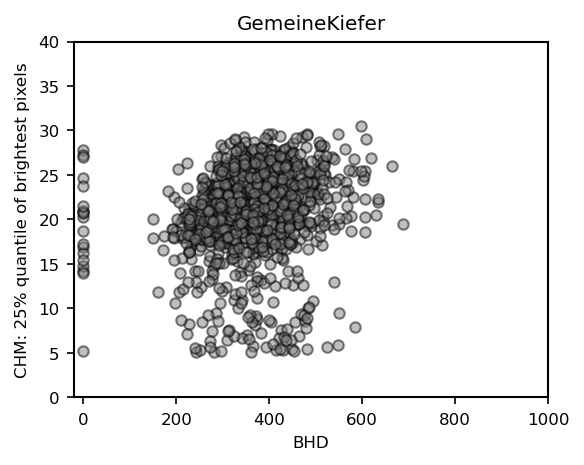

In [47]:
# Tree species mapper
mapper = descriptions.species_id_to_name()

############### Define a query string to filter all features
query_str = 'ba >= 0' # Select all tree species

ba_ids = [134] # Select 'Gemeine Kiefer'
# ba_ids = [118] # Select Gemeine Fichte'

query_str = 'ba in @ba_ids' # Query for tree species
query_str += ' and min_brightest_light > 1.5e-2' # Select all with min value of brightest px above fixed threshold
query_str += ' and kkl in [1,2]'

############### Which feature to plot
# name_x = ('min_brightest_light', r'Lightness: Min. of brightests pixels')
name_x = ('bhd_2020', r'BHD')
name_y = ('min_brightest_chm', r'CHM: 25% quantile of brightest pixels')


############### Some plotting specs
xlim = [-20, 1000]
ylim = [0, 40]

title_str = ''
for id in ba_ids: title_str += mapper[id].replace(' ', '') + '-'
title_str = title_str[:-1]

save_dir = r"C:\Users\flori\Documents\prof\lwf\plots\220722\bhd_vs_chm"
save_name = title_str + '__' + name_y[0] + '.pdf'

############### Plot histogram
x = np.array(df.query(query_str).loc[:, name_x[0]])
y = np.array(df.query(query_str).loc[:, name_y[0]])

f = plt.figure(figsize= [4, 3])
ax = f.add_subplot(111)

# Scatter plot
_ = ax.scatter(
    x,
    y,
    fc='grey',
    ec='k',
    alpha=0.5,
    )

ax.set_title(title_str)
_ = ax.set_xlabel(name_x[1])
_ = ax.set_ylabel(name_y[1])
_ = ax.set_xlim(xlim)
_ = ax.set_ylim(ylim)

# plt.savefig(os.path.join(save_dir, save_name), transparent=True)

#### Scatter plot: Playground

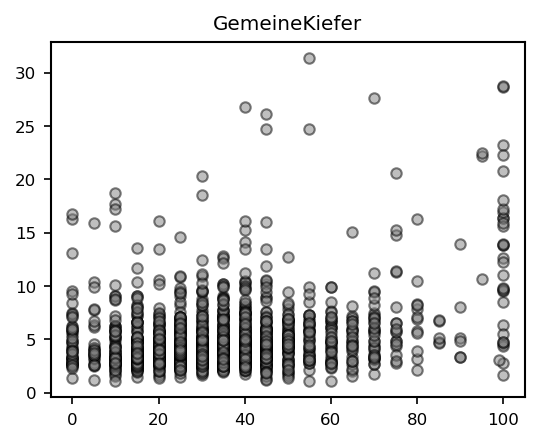

In [41]:
# Tree species mapper
mapper = descriptions.species_id_to_name()

############### Define a query string to filter all features
query_str = 'ba >= 0' # Select all tree species

ba_ids = [134] # Select 'Gemeine Kiefer'
# ba_ids = [118] # Select Gemeine Fichte'

query_str = 'ba in @ba_ids' # Query for tree species
# query_str += ' and min_brightest_light > 2e-2' 
# query_str += ' and n_px_brightest > 20'
# query_str += ' and kkl in [1,2]'

############### Which feature to plot
mean_ndvi = np.array(df.query(query_str).loc[:, 'mean_brightest_ndvi'])
median_ndvi = np.array(df.query(query_str).loc[:, 'median_brightest_ndvi'])
perc25_ndvi = np.array(df.query(query_str).loc[:, 'perc25_brightest_ndvi'])
perc75_ndvi = np.array(df.query(query_str).loc[:, 'perc75_brightest_ndvi'])
std_ndvi = np.array(df.query(query_str).loc[:, 'std_brightest_ndvi'])

median_red = np.array(df.query(query_str).loc[:, 'median_brightest_red'])
median_green = np.array(df.query(query_str).loc[:, 'median_brightest_green'])


nbv = np.array(df.query(query_str).loc[:, 'nbv'])

x = nbv
# y = (perc75_ndvi - perc25_ndvi) / median_ndvi
y = std_ndvi / mean_ndvi
# y = (median_red - median_green) / (median_red + median_green)

y *= 100

############### Some plotting specs
xlim = [-5,105]
ylim = [0, 30]

title_str = ''
for id in ba_ids: title_str += mapper[id].replace(' ', '') + '-'
title_str = title_str[:-1]

############### Plot histogram
f = plt.figure(figsize= [4, 3])
ax = f.add_subplot(111)

# Scatter plot
_ = ax.scatter(
    x,
    y,
    fc='grey',
    ec='k',
    alpha=0.5,
    )

ax.set_title(title_str)
_ = ax.set_xlim(xlim)
# _ = ax.set_ylim(ylim)

# plt.savefig(os.path.join(save_dir, save_name), transparent=True)